In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
import matplotlib.pyplot as plt
from testcase import *
import torch
from torch import nn
#from utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

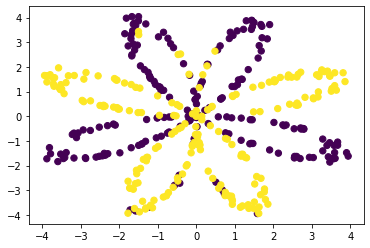

In [2]:
# PREDEFINED DATASET
def load_planar_dataset():
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

X,Y = load_planar_dataset()
# Visulaize the data
plt.scatter(X[0,:], X[1,:], c=Y[0], s=40);

In [3]:
# dataset info
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1] # training set size

print("The shape of X: " + str(shape_X))
print("The shape of Y: " + str(shape_Y))
print("The number of training examples: " + str(m))

The shape of X: (2, 400)
The shape of Y: (1, 400)
The number of training examples: 400


## Simple Logistic Regression using PyTorch

In [4]:
x = torch.from_numpy(X.T).float()
y= torch.from_numpy(Y.T).float()

In [6]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        outputs = self.linear(x)
        return outputs

# hyperparameter
epoch = 500
input_dim = 2
output_dim = 1
learning_rate = 0.01

model = LogisticRegression(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

for step in range(epoch):
    prediction = model(x)
    loss = criterion(input=prediction, target=y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 50 == 0:
        output = prediction >= torch.FloatTensor([0.5])
        accuracy = (output == y).float().sum()
        print('Epoch {:4d}/{} Cost: {:.3f} Accuracy: {:.3f}'.format(step, epoch, loss.item(), accuracy/x.shape[0]))

Epoch    0/500 Cost: 1.623 Accuracy: 0.500
Epoch   50/500 Cost: 0.474 Accuracy: 0.500
Epoch  100/500 Cost: 0.274 Accuracy: 0.510
Epoch  150/500 Cost: 0.242 Accuracy: 0.545
Epoch  200/500 Cost: 0.240 Accuracy: 0.493
Epoch  250/500 Cost: 0.240 Accuracy: 0.460
Epoch  300/500 Cost: 0.240 Accuracy: 0.458
Epoch  350/500 Cost: 0.240 Accuracy: 0.458
Epoch  400/500 Cost: 0.240 Accuracy: 0.458
Epoch  450/500 Cost: 0.240 Accuracy: 0.458


Text(0.5, 1.0, 'Logistic Regression using PyTorch')

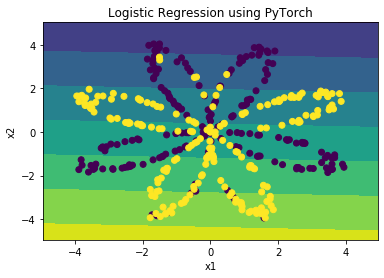

In [23]:
def plot_decision_boundary(model, X, Y):
    # set min and max values with some paddings
    x_min, x_max = X[0,:].min()-1, X[0,:].max() + 1
    y_min, y_max = X[1,:].min()-1, X[1,:].max() + 1
    h = 0.01
    # generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    x_temp = np.c_[xx.ravel(), yy.ravel()]
    x = torch.from_numpy(x_temp).float()
    
    # predict the function value for the whole grid
    Z = model(x)
    Z = Z.reshape(xx.shape) # tensor: need to DETACH
    # plot the contour and training examples
    plt.contourf(xx, yy, Z.detach().numpy())
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0,:], X[1,:], c=Y[0])
    return

# plot the decision boundary for logistic regression
plot_decision_boundary(model, X, Y)
plt.title("Logistic Regression using PyTorch")

The dataset is not linearly separable. We need a neural network!
## Neural Network

In [8]:
# layer_sizes
def layer_sizes(X, Y):
    n_x = X.shape[0] # size of input layer
    n_h = 4 # size of hidden layer
    n_y = Y.shape[0] # size of output layer
    
    return (n_x, n_h, n_y)

In [9]:
# initialize_parameters
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h,1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    return parameters

In [10]:
# forward_propagation
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert (A2.shape == (1, X.shape[1]))
    
    cache = {"Z1":Z1, "A1":A1, "Z2":Z2, "A2":A2}
    return A2, cache

In [11]:
# compute_cost
def compute_cost(A2, Y, parameters):
    m = Y.shape[1] # number of examples
    
    logprobs = Y * np.log(A2) + (1-Y) * np.log(1-A2)
    cost = -1 / m * np.sum(logprobs)
    cost = np.squeeze(cost)
    
    assert(isinstance(cost, float))
    return cost

In [12]:
# backward_propagation
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1] # number of examples
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    
    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T @ dZ2 * (1 - A1**2) 
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1":dW1, "db1":db1, "dW2":dW2, "db2":db2}
    return grads

In [17]:
# update_parameters
def update_parameters(parameters, grads, learning_rate=1.2):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # update rule
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    return parameters

## All-in-one

In [31]:
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    n_x = layer_sizes(X,Y)[0]
    #n_h = layer_sizes(X,Y)[1] #4
    n_y = layer_sizes(X,Y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)
        
        if print_cost and i % 1000 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
    
    return parameters

In [15]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5) * 1
    return predictions

In [32]:
parameters = nn_model(X, Y, n_h, num_iterations=10000, print_cost=True)

# accuracy
predictions = predict(parameters, X)
print()
print("Accuracy: %d" % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Cost after iteration 0: 0.692997
Cost after iteration 1000: 0.231708
Cost after iteration 2000: 0.191182
Cost after iteration 3000: 0.173454
Cost after iteration 4000: 0.163465
Cost after iteration 5000: 0.158557
Cost after iteration 6000: 0.153076
Cost after iteration 7000: 0.147695
Cost after iteration 8000: 0.140918
Cost after iteration 9000: 0.133976

Accuracy: 93%


### Tuning hidden layer size (DEFAULT: 4)

In [39]:
hidden_layer_sizes = [1,2,3,4,5,50,100]

for i, n_h in enumerate(hidden_layer_sizes):
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    predictions = predict(parameters, X)
    accuracy = (np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100
    print("Accuracy for {} hidden units: {}".format(n_h, accuracy))

Accuracy for 1 hidden units: [[67.25]]
Accuracy for 2 hidden units: [[64.5]]
Accuracy for 3 hidden units: [[92.]]
Accuracy for 4 hidden units: [[91.75]]
Accuracy for 5 hidden units: [[92.]]
Accuracy for 50 hidden units: [[93.25]]
Accuracy for 100 hidden units: [[92.5]]
